# Tutorial 1 - Analyzing scRNA-seq data at the Protein Activity Level

This Tutorial will guide the user thorugh the analysis of single-cell RNA-seq (scRNA-seq) data at the Protein Activity level using `pyviper`. Specifically, we will show how to transform a gene expression signature generated from sparse scRNA-seq data into a protein activity matrix using the [VIPER](https://www.nature.com/articles/ng.3593) algorithm. After a brief description of the installation procedure and the modules needed, this Jupyter Notebook is organized in the following sections.


**Table of Contents**

[Step 1. Load a gene expression signature for single cells](#1)\
[Step 2. Load and inspect a lineage-specific gene regulatory network](#2)\
[Step 3. Convert the gene expression signature into a protein activity matrix using VIPER](#3)\
[Step 4. Analyze single-cells at the Protein Activity level](#4)
[Key Takeaways](#5)

### Install PyVIPER
Install `pyviper` from PyPI using pip. Alternatively, refer to the README in the current GitHub to install from the local directory.

In [63]:
# !pip install pyviper

### Import modules
Load `pyviper` and additional modules required used in this tutorial.

In [64]:
import pyther
import scanpy as sc
import anndata 
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*") # for jit decorator issue with sc.pp.neighbors (09/30/2023)

Setup the path to the data.

In [65]:
data_location = "https://zenodo.org/records/10059791/files/"

We will import the data directly from the above link. Optionally, users are allowed to download the files from [here](https://zenodo.org/records/10059791) and to load them from their local computer. If the second option is preferred, the following lines can be uncommented and run to download the data on Unix systems and set the working directory to the path where the data will be stored. 

In [66]:
#!mkdir Tutorial_1_data_dir 
#%cd Tutorial_1_data_dir 
#!curl -O https://zenodo.org/records/10059791/files/Tutorial_1_gExpr_fibroblast_5802.tsv.gz -O https://zenodo.org/records/10059791/files/fibroblast-net.tsv 
#data_location = !pwd 
#data_location = data_location[0]+"/" # new value for data if working on data downloaded locally 

<a id='1'></a>
### Step 1. Load a gene expression signature for single-cells 
Load a gene expression signature to be used as input for the `viper` function for Protein Activity inference and store it as an [AnnData](https://anndata.readthedocs.io/en/latest/) object to enable interoperability with [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/#). The time required for this process is approximately 5 s and 30 s if loading from the local directory or remote url, respectively.

In [67]:
gene_expr_path = data_location + "Tutorial_1_gExpr_fibroblast_5802.tsv.gz"

gene_expr_signature = pd.read_csv(gene_expr_path, sep="\t") # read from remote 
gene_expr_signature = sc.AnnData(gene_expr_signature) # convert to AnnData object

This signature was generated from a population of cancer-asssociated fibroblasts (CAFs) from publicly avaiable data from [Peng et al., 2019](https://www.nature.com/articles/s41422-019-0195-y) following a similar procedure to the one described in Tutorial 2. 

Display matrix dimensions with cells on rows and features (genes) on columns. 

In [68]:
gene_expr_signature

AnnData object with n_obs × n_vars = 5802 × 5000

<a id="2"></a>
### Step 2. Load an inspect a lineage-specific gene regulatory network
Load and inspect a lineage-specific gene regulatory network generated with the [ARACNe3](https://www.mdpi.com/1099-4300/25/3/542). The time required to load a network is approximately 1 s (from local directory) and 40 s (from remote url). 

In [69]:
network_path = data_location + "fibroblast-net.tsv" # path to ARACNe network
    
network = pd.read_csv(network_path, delimiter="\t")

Convert the pd.DataFrame to an object of class `Interactome` to enable easier manipulation. Show the number of regulons using the `size()` method. You can see all available methods by typing `help(pyther.Interactome)`.

In [70]:
network_interactome = pyther.Interactome('fibroblasts', network) # convert to class Interactome
network_interactome.size() # show number of regulons in the Interactome

6437

Display the first 5 interactions in the regulatory network. `mor` and `likelihood` are the mode of regulation of the given regulator-target pair and the likelihood of the interaction, respectively. Algorithms other than ARACNe can be used to generate gene regulatory networks, but we recommend postprocessing the output to suitable data formats to use `viper`.


In [71]:
network_interactome.net_table.head()

,regulator,target,mor,likelihood
0,AATF,CCM2,0.012159,0.999799
1,AATF,THOC2,0.007487,0.999597
2,AATF,RAP1A,-0.021062,0.999396
3,AATF,SFT2D1,0.019400,0.999195
4,AATF,DNAJC2,0.047129,0.998993


Filter out targets in the `Interactome` that are not present in the gene expression matrix. This step is recommended before running `viper`. 

In [72]:
network_interactome.filter_targets(gene_expr_signature.var_names)

As an example, display the number of targets of two regulators, MYC and EGFR2.

In [73]:
n_MYC = len(network_interactome.get_reg('MYC')) # number of MYC targets in the network
n_EGFR = len(network_interactome.get_reg('EGFR')) # number of SERPINA12 targets in the network

print("The number of targets of MYC and SERPINA12 are " + str(n_MYC) + " and " + str(n_EGFR) + ", respectively.")

The number of targets of MYC and SERPINA12 are 284 and 183, respectively.


<a id='3'></a>
### Step 3. Convert the gene expression signature into a protein activity matrix using VIPER
`viper` transforms a gene expression signature into a protein activity matrix by performing enrichment analysis on regulons. Two methods for enrichment analysis are available, [aREA](https://www.nature.com/articles/ng.3593) (default) and [NaRnEA](https://www.mdpi.com/1099-4300/25/3/542) (by setting `enrichment="narnea"`).

#### Method 1 - protein activity inference using aREA
As shown above, different regulators can have a different number of targets. Prune each regulon to have the same number of targets (50 in this case). This preprocessing step is advisable to avoid regulators with exceedingly number of targets dominating those having fewer in the computation of Normalized Enrichment Scores (NES), to make NES comparable.

In [74]:
network_pruned = network_interactome.copy() # generate a copy of the unpruned network before pruning it
network_pruned.prune(max_targets=50,eliminate=True) # prune interactome to have exactly 50 targets

Now all the regulators in the network have exactly 50 transcriptional targets. See e.g. MYC and EGFR2.

In [75]:
n_MYC = len(network_pruned.get_reg('MYC')) # number of MYC targets in the network
EGFR = len(network_pruned.get_reg('EGFR')) # number of SERPINA12 targets in the network

print("Number of MYC targets: " + str(n_MYC) + "\nNumber of EGFR targets: " + str(EGFR))

Number of MYC targets: 50
Number of EGFR targets: 50


<div class="alert alert-block alert-success">
<b></b> Run `viper` to compute the protein activity matrix with aREA.
</div>
 
Mandatory inputs to `viper` are 1. a gene expression signature and 2. a gene regulatory network. Set the `viper` output to be an ndarray (The default output would be an AnnData object). The expected runtime is approximately 10-15 s.

In [76]:
ProtAct_aREA = pyther.viper(gex_data=gene_expr_signature, # gene expression signature
                             interactome=network_pruned, # gene regulatory network
                             enrichment = "area",
                             output_as_anndata=False,
                             njobs=1,
                             verbose=False)

`ProtAct_aREA` contains the activity of every regulatory protein described by its NES for each single cell.

In [77]:
ProtAct_aREA # display the protein activity matrix 

regulator,AAMP,AATF,ABCA1,ABCA12,ABCA3,ABCA7,ABCA8,ABCB1,ABCB4,ABCB5,...,ZSWIM5,ZSWIM6,ZSWIM7,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
T1_AAACCTGAGATGTCGG,-0.014206,0.027712,0.057313,0.095473,-0.021236,0.038511,-0.598815,-1.505867,0.044179,-0.032513,...,0.157645,0.190605,-1.006026,-0.016635,0.053824,-0.483114,-0.164187,0.598380,-0.219886,0.042218
T1_AACTGGTTCTAACGGT,-0.251498,0.049527,0.058710,0.086291,-0.130560,0.008993,-0.170331,-0.038688,-0.033160,-0.023936,...,0.050540,-0.001874,0.852565,-0.003012,0.046448,-0.073733,0.650326,1.442805,0.026046,-0.014535
T1_AAGGTTCGTGTCAATC,-0.436400,0.058650,0.071995,0.085530,0.007212,-0.037141,-0.350010,-0.271247,0.026917,-0.005419,...,0.588326,-0.040662,0.265022,-0.185548,-0.007104,-0.078222,0.020503,-0.784129,-0.116486,0.008290
T1_ACAGCCGTCAAGCCTA,-1.034668,0.052937,0.096666,0.110275,-0.019219,-0.021259,-0.021779,-0.703762,0.007190,-0.045264,...,0.167126,0.056834,0.557881,-0.548752,-0.010246,-0.044021,-0.007267,0.501714,-0.001597,-0.007290
T1_AGACGTTAGGCGACAT,-0.811760,0.043792,0.066080,0.069523,-0.035705,-0.035428,-0.317873,0.037946,-0.005969,-0.024018,...,0.104896,-0.012483,-0.457026,0.211869,-0.144309,-0.019348,-0.035585,0.085054,-0.352943,-0.011871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T24_TTGCGTCCAGACAAAT,0.002299,0.013470,0.060106,1.236346,0.018945,0.028562,-0.093820,-1.275721,-1.226240,0.386276,...,-0.031268,-0.062835,-0.006546,0.019039,0.068665,-0.544908,0.573362,-0.551146,-0.000499,-0.129102
T24_TTGCGTCCATTAACCG,-0.129001,0.034863,0.089672,0.044609,0.040947,-0.078091,-0.200762,-0.007241,0.042752,-0.070949,...,0.024643,-0.484168,-0.022466,-0.023258,-0.045327,-0.041769,-0.025815,-0.003803,-0.054201,-0.011256
T24_TTTATGCTCCTTTACA,-0.354839,0.036691,0.062033,0.054651,-0.018591,0.102881,-0.535426,-0.809012,0.000806,0.072612,...,0.074007,0.091054,0.080505,0.003998,0.030402,-0.000688,-0.049335,-1.073907,-0.215079,0.007779
T24_TTTCCTCCACCGGAAA,-0.742043,0.049942,0.065039,0.105232,0.236517,-0.762427,-0.290367,1.586747,0.020128,-0.075647,...,0.032234,0.398886,-0.547757,-0.016941,0.260247,-0.038721,0.012140,0.437124,-0.040129,-0.040400


#### Method 2 - protein activity inference using (matrix)-NaRnEA

<div class="alert alert-block alert-success">
<b></b> Run `viper` to compute the protein activity matrix using (matrix-based) NaRnEA .
</div>
 

Compute the protein activity using `viper` with NaRnEA as the enrichment method. Unlike aREA, the NaRnEA framework is suitable also for regulons of different size. Store the output in an `AnnData` object (default).

In [78]:
ProtAct_NaRnEA = pyther.viper(gex_data=gene_expr_signature, # gene expression signature
                                 interactome=network_interactome, # gene regulatory network
                                 enrichment = "narnea",
                                 njobs=1,
                                 verbose=False)

Show the output type and length of `ProtAct_NaRnEA`.

In [79]:
ProtAct_NaRnEA # display the protein activity matrix as AnnData object 

AnnData object with n_obs × n_vars = 5802 × 6413
    uns: 'gex_data'
    layers: 'pes'

When run with the NaRnEA method, `viper` returns an additional layer, `pes` that stores the Proportional Enrichment Score (PES) of each regulator, a measure of protein activity in the $-1 \le PES \le 1$ interval that can be used as an enhanced measure of effect size of each regulon's activity. For further details, see [Griffin et al., 2022](https://pubmed.ncbi.nlm.nih.gov/36981431/).

Display NES protein activity matrix.


In [80]:
ProtAct_NaRnEA.to_df() # NES matrix

,AAMP,AATF,ABCA1,ABCA12,ABCA3,ABCA7,ABCA8,ABCB1,ABCB4,ABCB5,...,ZSWIM5,ZSWIM6,ZSWIM7,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
T1_AAACCTGAGATGTCGG,4.715789,-6.613786,7.001248,1.851045,1.843629,-0.857881,14.543342,-0.613878,-0.824745,0.406057,...,-1.862346,3.146378,-7.006648,-0.756162,-2.003027,1.459852,2.712799,5.787629,2.397046,-2.582086
T1_AACTGGTTCTAACGGT,-7.191714,7.533881,9.429433,4.088336,-0.461214,1.055557,-18.886093,1.401654,-0.798170,1.079553,...,2.199012,-3.213969,-7.219745,0.821136,1.227563,-1.558459,-1.394093,12.747848,1.822417,2.953031
T1_AAGGTTCGTGTCAATC,8.887137,-9.449057,-10.272199,3.190093,-1.265178,0.657827,20.582304,0.466253,-0.916708,0.486921,...,1.655850,3.406829,-8.988820,-1.780032,-0.947679,-2.583600,1.037094,-11.109167,-1.955563,-2.474079
T1_ACAGCCGTCAAGCCTA,7.847414,6.900573,9.575873,-2.852121,-0.872999,-1.455654,23.062950,-0.603498,1.127638,0.936162,...,-1.165667,-2.528141,-6.812299,-1.115750,-1.571316,1.245981,2.074361,-11.699137,2.160041,2.499193
T1_AGACGTTAGGCGACAT,7.643162,6.953849,-8.838992,2.588946,0.552425,-0.694912,-15.233547,0.163285,2.939726,-0.930142,...,1.883423,-2.452158,-9.295234,0.852636,1.995564,-1.274296,-2.888875,8.253686,-2.171622,3.023637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T24_TTGCGTCCAGACAAAT,3.929488,3.904004,-7.629382,-2.257839,0.547175,-1.310761,10.857200,0.809013,-1.093720,1.711279,...,-2.431247,2.670952,5.755338,0.977276,-2.342592,-0.952300,1.586434,6.731536,2.967126,1.218217
T24_TTGCGTCCATTAACCG,-7.197257,7.793606,8.194140,-2.333065,-1.661859,1.403345,-19.088629,0.623605,-0.571697,-1.285721,...,1.153792,-2.933194,7.263271,-0.940619,-1.737071,1.691363,-1.825287,10.659641,1.579409,2.971451
T24_TTTATGCTCCTTTACA,-7.103387,8.042507,-8.372260,2.609825,0.896921,-2.094449,20.645484,-0.346492,0.872927,-0.579501,...,1.109876,2.796211,6.435829,1.046557,1.433361,-1.580545,1.450763,-10.226545,1.772312,2.924802
T24_TTTCCTCCACCGGAAA,-6.267298,-5.975001,-6.912350,-3.515971,0.877991,-1.020563,-11.196501,0.534728,-1.318767,0.807623,...,1.258743,-3.328178,5.359631,-2.210881,-1.586171,-1.064334,0.944330,-6.458201,-1.191704,2.884055


Display the PES protein activity matrix.

In [81]:
ProtAct_NaRnEA.to_df(layer="pes") # PES matrix

,AAMP,AATF,ABCA1,ABCA12,ABCA3,ABCA7,ABCA8,ABCB1,ABCB4,ABCB5,...,ZSWIM5,ZSWIM6,ZSWIM7,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
T1_AAACCTGAGATGTCGG,0.240772,-0.304270,0.281038,0.074875,0.065383,-0.030209,0.378750,-0.021176,-0.028191,0.012894,...,-0.057990,0.109255,-0.352088,-0.026435,-0.069684,0.050031,0.092210,0.262122,0.085055,-0.092093
T1_AACTGGTTCTAACGGT,-0.377572,0.314127,0.353572,0.160783,-0.015217,0.035737,-0.497909,0.047375,-0.026517,0.033253,...,0.065166,-0.115518,-0.365130,0.029192,0.042427,-0.052575,-0.044594,0.546236,0.062533,0.098134
T1_AAGGTTCGTGTCAATC,0.411746,-0.426309,-0.463015,0.121526,-0.039884,0.021507,0.489378,0.015299,-0.029489,0.014491,...,0.047115,0.107279,-0.455701,-0.057125,-0.030605,-0.084660,0.033765,-0.547947,-0.066875,-0.085122
T1_ACAGCCGTCAAGCCTA,0.373952,0.280809,0.347536,-0.110712,-0.028223,-0.049295,0.563023,-0.019842,0.036926,0.028396,...,-0.035112,-0.090271,-0.344878,-0.036706,-0.051855,0.040700,0.068411,-0.576989,0.072889,0.081400
T1_AGACGTTAGGCGACAT,0.367726,0.285936,-0.395159,0.100920,0.019161,-0.023652,-0.399057,0.005474,0.096805,-0.028409,...,0.055218,-0.087718,-0.469730,0.030140,0.068457,-0.042643,-0.091376,0.348384,-0.075733,0.099308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T24_TTGCGTCCAGACAAAT,0.204446,0.174607,-0.337181,-0.093020,0.019611,-0.046764,0.288005,0.028439,-0.037907,0.055128,...,-0.076656,0.094553,0.273277,0.035624,-0.082810,-0.033380,0.054557,0.311536,0.106925,0.042919
T24_TTGCGTCCATTAACCG,-0.379965,0.335563,0.321241,-0.093680,-0.056283,0.048430,-0.508088,0.021407,-0.019326,-0.040297,...,0.034984,-0.105993,0.329845,-0.032393,-0.059631,0.057258,-0.059820,0.473351,0.055332,0.101333
T24_TTTATGCTCCTTTACA,-0.374228,0.343792,-0.370403,0.103941,0.031494,-0.072713,0.525797,-0.011750,0.029375,-0.018084,...,0.033471,0.094812,0.289742,0.037420,0.050027,-0.053926,0.048746,-0.502225,0.061779,0.099145
T24_TTTCCTCCACCGGAAA,-0.332941,-0.275806,-0.310930,-0.140664,0.031023,-0.035522,-0.299154,0.018338,-0.044461,0.025257,...,0.037913,-0.120995,0.238777,-0.075475,-0.054143,-0.036417,0.031897,-0.320772,-0.042458,0.097503


Notice that when setting the `viper` output to be an object of class `AnnData`, the input gene expression matrix is saved under the attribute `gex_data` of the output `AnnData` object:

In [82]:
ProtAct_NaRnEA.uns["gex_data"][0:5,0:5].to_df()

,RP11-54O7.3,SAMD11,PLEKHN1,RP11-54O7.17,HES4
T1_AAACCTGAGATGTCGG,-0.145409,-0.513375,-0.130302,-0.134275,1.855504
T1_AACTGGTTCTAACGGT,-0.108846,-0.390002,-0.096722,-0.101255,2.064095
T1_AAGGTTCGTGTCAATC,-0.084144,-0.306366,-0.074026,-0.078937,1.387576
T1_ACAGCCGTCAAGCCTA,-0.099796,-0.359357,-0.088408,-0.093080,-0.622520
T1_AGACGTTAGGCGACAT,-0.099830,-0.359472,-0.088440,-0.093111,3.986061


<a id='4'></a>
### Step 4. Analyze single-cells at the Protein Activity level 
This section presents some useful postprocessing functions that can be used on the protein activity matrix. 

First, set the set of regulatory proteins to be those for the human species. This is step is redundant, since `pyviper` sets `"human"` as default, but it demonstrates how to have complete control over the analysis, if fine-tuning is desired.  

In [83]:
pyther.config.set_regulators_species_to_use(species="human")

Run PCA to reduce the dimensionality of the dataset, by projecting the PES of transcriptional regulators (TFs) and co-transcriptional regulators (coTFs) by setting `filter_by_feature_groups=["tfs", "cotfs"]`. In this example, we focus on TFs and coTFs, major mechanistic determinants of cell state as shown in [Paull et al., 2021](https://www.sciencedirect.com/science/article/pii/S0092867420316172?via%3Dihub) and [Califano & Alvarez, 2016](https://www.nature.com/articles/nrc.2016.124). Possible options for this parameter are `["tfs", "cotfs", "sig", "surf"]`, where the latter refer to signaling proteins and surface markers, respectively. Set `None` to use all the features in the protein activity matrix.

In [84]:
pyther.tl.pca(ProtAct_NaRnEA, layer="pes", filter_by_feature_groups=["tfs","cotfs"], zero_center=True,  svd_solver='arpack')

(5802, 2164)


The `tl` module provides wrappers to several `scanpy.tl` functions, and it can be used to simplify the postprocessing of protein activity data, for instance by subsetting the class of regulatory proteins to analyze, as shown in the cell above. 

Compute the neighbors graph of cells using the PCA representation of the protein activity matrix. For sake of simplicity, set `n_neighbors = 20`and `n_pcs = 50` (please, notice that typically, these parameters need tuning).

In [85]:
sc.pp.neighbors(ProtAct_NaRnEA, metric="correlation", n_neighbors=20, n_pcs=50)

Cluster cells based on their protein activity profiles using the Leiden algorithm with `resolution=0.1` (in real-world applications this parameter should also be optimized).

In [86]:
sc.tl.leiden(ProtAct_NaRnEA, resolution=0.1, n_iterations=-1)

Generate a [UMAP](https://arxiv.org/abs/1802.03426) embedding for the graph. 

In [87]:
sc.tl.umap(ProtAct_NaRnEA)

Display the 2-dimensional UMAP embedding using the `pyther.pl` module for easier post-processing of key protein activity features. Color by cluster.  

/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


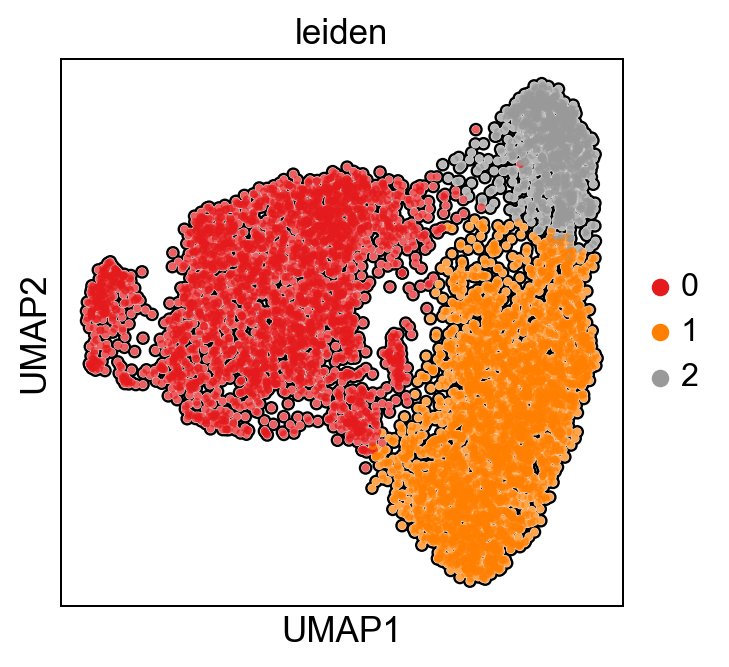

In [88]:
sc.set_figure_params(dpi=90)
n_cells = ProtAct_NaRnEA.shape[0]
dot_size = 120000 / n_cells*2
pyther.pl.umap(ProtAct_NaRnEA, color='leiden', palette="Set1", size=dot_size,add_outline=True)

Identify the most active regulators in each cluster by cluster-based integration of their NES using the Stouffer's method: $$ NES^C_j = \frac{\sum_{k \in C}NES_{k,j}}{\sqrt{n^C}} $$ where $NES^C_j$ denotes the integrated NES for regulator $j$ in cluster $C$, $NES_{k,j}$ is the NES of regulator $j$ in cluster $C$ and $n^C$ is the number of cells in cluster $C$.

In [89]:
ProtAct_NaRnEA = pyther.tl.stouffer(ProtAct_NaRnEA, "leiden", filter_by_feature_groups=["tfs","cotfs"]) # Stouffer integration 

/Users/lucazanella7/Desktop/ColumbiaProjects/pyther/pyther/tl.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['stouffer'] = result_df


Display the integrated NES scores in each cluster, are stored in `.uns` under`stouffer`.

In [90]:
NES_integrated = ProtAct_NaRnEA.uns["stouffer"] 
NES_integrated

,AATF,ABCG1,ABCG4,ABLIM3,ABT1,ACAD8,ACTN2,ACTR5,ADH1A,ADNP,...,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZXDA,ZXDB,ZXDC,ZZEF1
0,-70.545457,-138.184298,-22.089703,-20.922626,35.180190,38.636582,-2.742095,-34.471444,12.280598,-161.997831,...,32.843922,24.850881,-32.386419,11.739289,-52.299440,80.082544,26.335577,-13.956471,27.841052,20.810017
1,77.543189,121.805108,25.858757,-28.877475,-110.167552,-32.865611,-14.695282,-46.184546,4.389829,-39.254082,...,-9.167898,-24.095579,63.343214,19.602702,-70.728236,-27.544471,-11.446362,-0.517235,-26.099347,-24.120022
2,149.999258,103.790822,-30.828134,-10.866405,261.643008,38.576960,-16.990729,0.361454,11.197243,-155.476617,...,19.677948,-28.490147,-10.558517,-3.983134,-74.026399,54.760888,4.959210,-27.063909,26.828891,-44.774183


Analogously, the function `stouffer_clusters_df` can be used to performed the same operations on pd.DataFrames. Remove ribosomal proteins from the Stouffer-integrated matrix (ribosomal protein genes are among the most highly expressed genes in most cell types).

In [91]:
filtered_proteins = NES_integrated.columns[~NES_integrated.columns.str.startswith('RP')].to_list() # Exclude columns starting with 'RP' from integrated matrix
NES_integrated = NES_integrated.loc[:,filtered_proteins] # remove ribosomal proteins from DataFrame

Select the 10 most activated regulatory protein in each cluster.

In [92]:
active_proteins = NES_integrated.apply(lambda row: row.nlargest(10).index.tolist(), axis=1)  # the top 10 most activated proteins in each cell type
active_proteins

0    [TSHZ2, NFIA, NFIB, ZBTB16, TCF21, IGF1, TSC22...
1    [INHBA, MMP14, ID3, LOXL2, HOPX, RUNX2, LEF1, ...
2    [ENO1, NACA, PFDN5, HMGA1, BTF3, LOXL2, CCDC85...
dtype: object

Finally, display the top activated proteins from `ProtAct_NaRnEA` on a heatmap

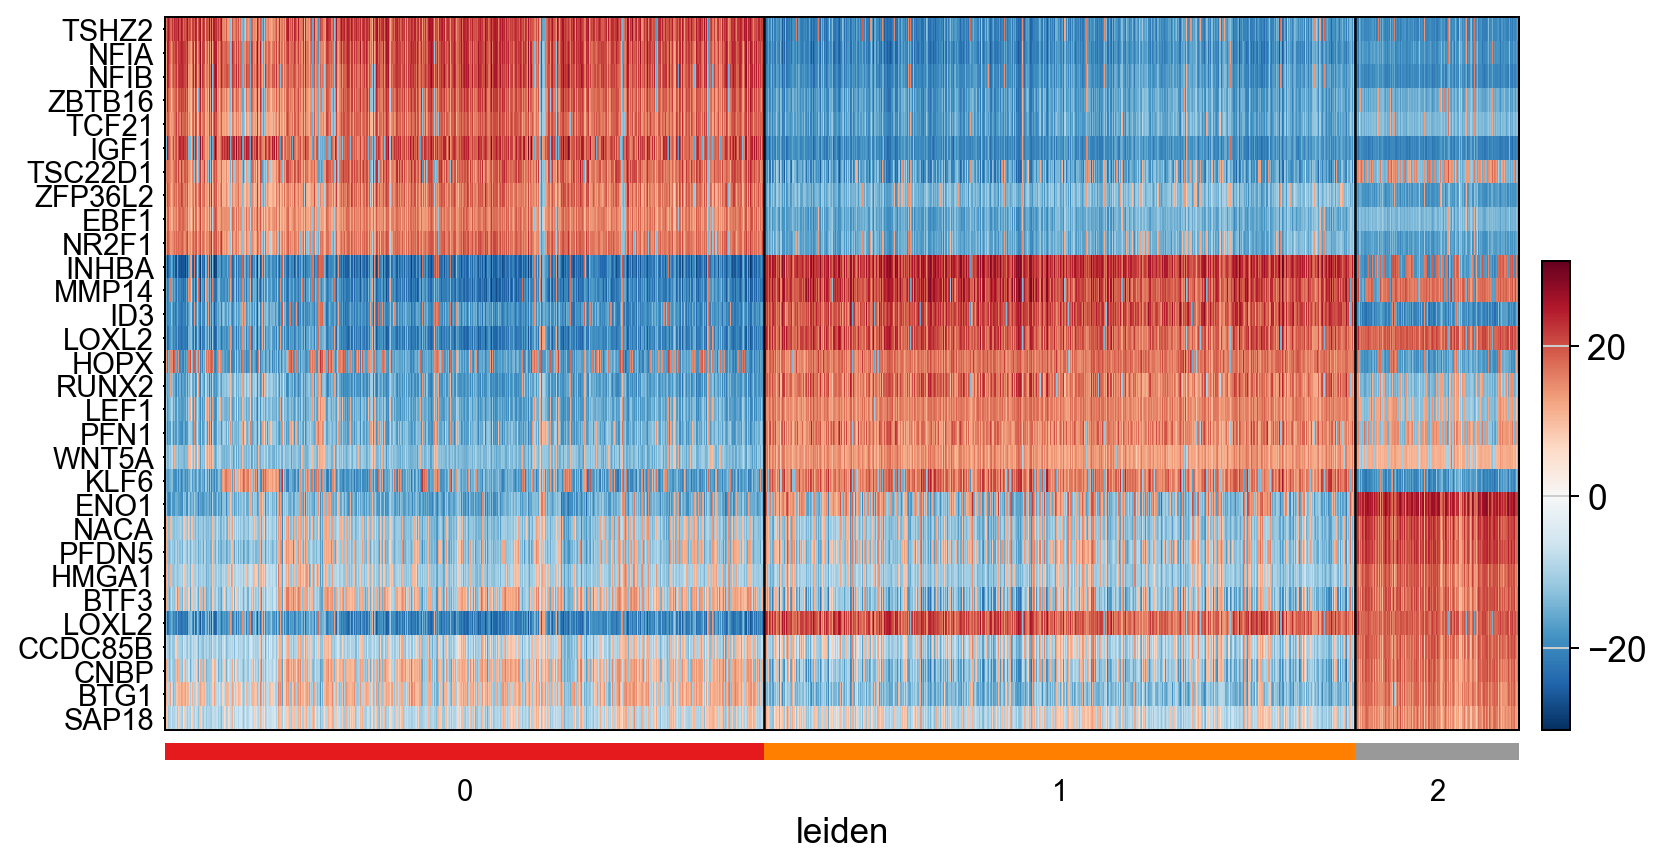

In [93]:
protein_set = active_proteins.sum() # protein set to display on the heatmap
ax = pyther.pl.heatmap(ProtAct_NaRnEA, var_names=protein_set, groupby="leiden", vcenter=0, cmap="RdBu_r",dendrogram=False,swap_axes=True, show_gene_labels=True)

<a id='5'></a>
### Key takeaways
This Tutorial describes how to inspect and process gene regulatory networks, by manipulating objects of class `Interactome`, and shows how to generate protein activity profiles from single-cell data using the `viper` function. Last, we presented key functions for the post-processing and visualization of protein activity data. In Tutorial 2 we will introduce the user to the generation of suitable gene expression signatures for `viper` and extend the VIPER analysis to simultaneously account for multiple cell pupulations through the exploitation of the [metaVIPER](https://www.nature.com/articles/s41467-018-03843-3) paradigm.   